# Assignment 3
Prepared by Talha Alvi and Farhan Wadia

## Exercise 1 (Programming Exercise)

Refer to a description of the shared autonomous vehicle (SAV) problem [here](https://smartmobilityalgorithms.github.io/book/content/PeopleMobilityProblems/carsharing/CarSharing.html). The purpose of this notebook is to extend on this work by implementing the problem for 3 vehicles instead of 1 or 2, and by developing an adaptive genetic algorithm, particle swarm optimization, and adaptive particle swarm optimization as alternative methods for solving the problem. 

### Data

In [1]:
import pandas as pd
from smart_mobility_utilities.poi import poi
from smart_mobility_utilities.poi import drawRouteOrder
from smart_mobility_utilities.problem import ordOne_crossover, swap_mutation
from copy import deepcopy
import random
from heapq import nlargest
import matplotlib.pyplot as plt

depots = pd.read_csv("./carshare_depot.csv")
depot_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in depots.iterrows()]
pickups = pd.read_csv("./carshare_origin.csv")
pickup_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in pickups.iterrows()]
dropoffs = pd.read_csv("./carshare_dest.csv")
dropoff_nodes = [poi(row['address'],'canada',row['lat'],row['lng']) for index, row in dropoffs.iterrows()]

# Import a pre-calculated trip distance matrix
# These distances are based off of an osrm routing
tm = pd.read_csv("./trip_matrix.csv").values
trip_matrix = {}
all_points = depot_nodes + pickup_nodes + dropoff_nodes
for point in all_points:
    i = all_points.index(point)
    trip_matrix[point] = {}
    for point2 in all_points:
        j = all_points.index(point2)
        trip_matrix[point][point2] = tm[i][j+1]

### Genetic Algorithm

#### Solution Class

In [2]:
class GACarSharingSolver:
    def __init__(
        self,
        depot_nodes,
        pickup_nodes,
        dropoff_nodes,
        trip_matrix,
        pop_size,
        iterations,
        num_parents,
        mutation_prob,
        crossover_prob,
        pre_avoid = [],
        post_avoid = []
    ):

        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.pop_size = pop_size
        self.iterations = iterations
        self.num_parents = num_parents
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.population = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid
        random.seed(21) # arbitrary random seed to make results reproducible

    def crossover(parent1, parent2):
        return ordOne_crossover(parent1, parent2)

    def mutation(permutation):
        return swap_mutation(permutation)

    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        #print(route)
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def initial_population(self):
        self.population = [
            self.random_solution()
            for _ in range(self.pop_size)
        ]
        self.costs = self.fitness(self.population)

    # Single vehicle, genetic algorithm
    def run(self):
        # Check that initial population exists:
        if self.population:
            # Show some information
            print("Initial Population costs:")
            print(self.costs)
        else:
            raise Exception("Population not initialized.")
        
        for x in range(self.iterations):
            self.costs = self.fitness(self.population)
            #print("Iter: ")
            #print(x)
            #print(" ")
            #print(self.costs)
            self.states.append(max(self.costs))
            # Select the parents, we want to maximize the profit
            parents = nlargest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            # Need to remove depots from the routes
            parents = [x[1:-1] for x in parents]
            offspring = []
            new_population = []
            for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
                # Crossover probability
                if random.random() < self.crossover_prob:
                    offspring.append(GACarSharingSolver.crossover(p1,p2))
                    offspring.append(GACarSharingSolver.crossover(p2,p1))
                else:
                    offspring.append(p1)
                    offspring.append(p2)
            for child in offspring:
                sig = 1 - 0.9*(x/self.iterations)
                if random.random() < sig:
                    new_population.append(GACarSharingSolver.mutation(child))
                else:
                    new_population.append(child)
            new_population.extend(parents)
            self.population = [self.find_depots(route) for route in new_population]

        # Show best solution
        self.costs = self.fitness(self.population)
        self.states.append(max(self.costs))
        self.solution = max(self.population,key= lambda x: self.costs[self.population.index(x)])
        self.solution_cost = self.costs[self.population.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        # print("States:", self.states)
        

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

#### Single Vehicle Check

In [3]:
pop_size = 16
iterations = 1000
num_parents = 8
mutation_prob = 0.3
crossover_prob = 0.7

solver = GACarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes, 
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob)

# Initialize the population
solver.initial_population()
solver.run()

Initial Population costs:
[5888.39, 6094.43, 5158.37, 6299.27, 1825.34, 8240.51, 5162.81, 6765.41, 2960.24, 7400.6, 9198.98, 7501.37, -2925.43, 5498.15, 2580.92, 1468.25]
Best Solution: [Name: 93 ID: 4035051033, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 93 ID: 4035051033]
Best Solution Profits: 18265.37


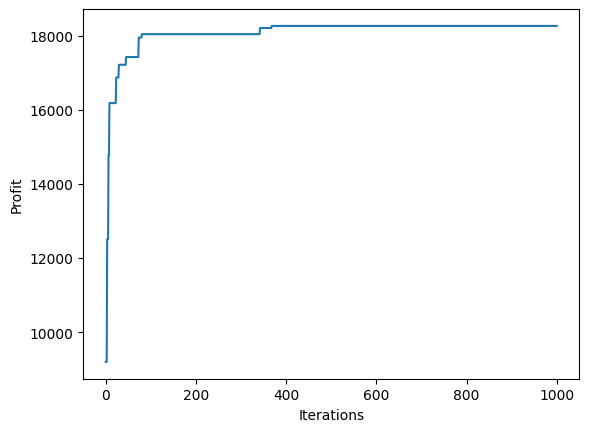

In [4]:
solver.visualize_graph()

##### Route Visualization

In [5]:
solver.visualize_solution()

#### Vehicle Partitioning for 3 Vehicle Solution

For simplicity, assume that the 3 vehicle solution can be implemented by partitioning the set of dropoffs into 3 subsets (one for each vehicle), treating each as a single vehicle routing problem, and then combining the solutions. This method should give feasible solutions, but solutions that are closer to optimal would require modifying the solution classes for all of the algorithms to support multiple vehicles so that ideal subsets of pickups/dropoffs per vehicle can be found.

Partitions were chosen arbitrarily based on trial and error with segmenting the pickup and dropoff points in the visualization below. The order of segmenting the vehicles (since this affects the locations of depots available at the start/end of each trip) was also explored with this trial and error. Note that the locations of the possible start/end depots are not shown.

In [6]:
import folium
from folium import Map, Marker, PolyLine, Icon

m = Map(location=pickup_nodes[0].coordinates[::-1], zoom_start=11)
icon_colors = ["#2e86ab","#a23b72","#f18f01","#c73e1d","#fe5f55", "#8ac926", "#ca6163", "#d1345b", "#bof2b4", "#f0e100"]

# Arbitrary partitions
first_vehicle_index = [0, 1, 4]
second_vehicle_index = [7, 8, 9]  
third_vehicle_index = [3, 5, 6, 2]

for i, x in enumerate(pickup_nodes):
    if pickup_nodes.index(x) in first_vehicle_index:
        c  = "black"
    if pickup_nodes.index(x) in second_vehicle_index:
        c = "lightgray"
    if pickup_nodes.index(x) in third_vehicle_index:
        c = "lightblue"
    
    # Plot pickup point with user icon
    Marker(location=x.coordinates[::-1], 
           popup="Pickup Node " + str(i) + "\n" + str(x.coordinates),
           icon=folium.Icon(color=c, icon_color=icon_colors[i], icon='user', prefix='fa')).add_to(m)
    
    # Plot dropoff point with home icon
    Marker(location=dropoff_nodes[i].coordinates[::-1], 
           popup="Dropoff Node " + str(i) + "\n" + str(dropoff_nodes[i].coordinates),
           icon=folium.Icon(color=c, icon_color=icon_colors[i], icon='home', prefix='fa')).add_to(m)

bathurst_start = [43.82720773214452, -79.45379689449601]
bathurst_end = [43.636628218276, -79.3998242335392]
PolyLine([bathurst_start, bathurst_end], color="red").add_to(m)

m

#### 3 Vehicle Solution

In [7]:
first_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in first_vehicle_index]
first_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in first_vehicle_index]
second_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in second_vehicle_index]
second_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in second_vehicle_index]
third_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in third_vehicle_index]
third_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in third_vehicle_index]

In [8]:
first_solver = GACarSharingSolver(
    depot_nodes, 
    first_pickups, 
    first_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob)

print("Vehicle A")
first_solver.initial_population()
first_solver.run()

second_solver = GACarSharingSolver(
    depot_nodes, 
    second_pickups, 
    second_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0], first_solver.solution[-1]],
    post_avoid = [first_solver.solution[0], first_solver.solution[-1]])

print("\nVehicle B")
second_solver.initial_population()
second_solver.run()

third_solver = GACarSharingSolver(
    depot_nodes, 
    third_pickups, 
    third_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_prob, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0], first_solver.solution[-1], second_solver.solution[0], second_solver.solution[-1]],
    post_avoid = [first_solver.solution[0], first_solver.solution[-1], second_solver.solution[0], second_solver.solution[-1]])

print("\nVehicle C")
third_solver.initial_population()
third_solver.run()

print("\nTotal profit:", first_solver.solution_cost + second_solver.solution_cost + third_solver.solution_cost)

Vehicle A
Initial Population costs:
[3410.79, 1942.56, 3410.79, 4403.22, 3410.79, 5555.04, 5555.04, 1942.56, 3410.79, 4403.22, 5555.04, 5555.04, 3410.79, 5441.22, 4403.22, 5555.04]
Best Solution: [Name: 93 ID: 4035051033, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 93 ID: 4035051033]
Best Solution Profits: 5555.04

Vehicle B
Initial Population costs:
[-1704.74, 404.47, -1704.74, 1302.37, -1704.74, -1704.74, -1704.74, 404.47, -1704.74, 1302.37, -1704.74, -1704.74, -1704.74, -54.32, 1302.37, -1704.74]
Best Solution: [Name: Optima ID: 96156270, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: Optima ID: 96156270]
Best Solution Profits: 1302.37

Vehicle C
Initial Population costs:
[4423.45, 1892.2, 7164.43, 2472.94, 5328.7

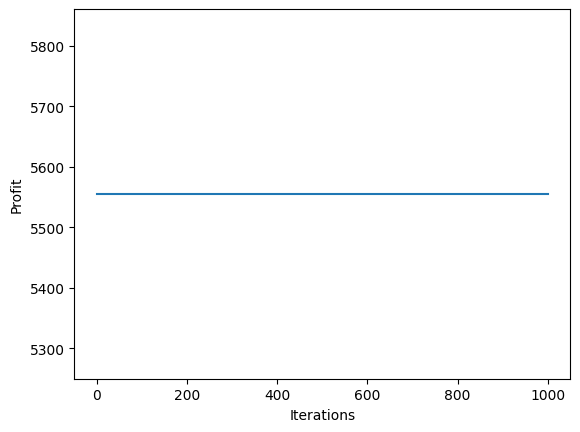

In [9]:
first_solver.visualize_graph()

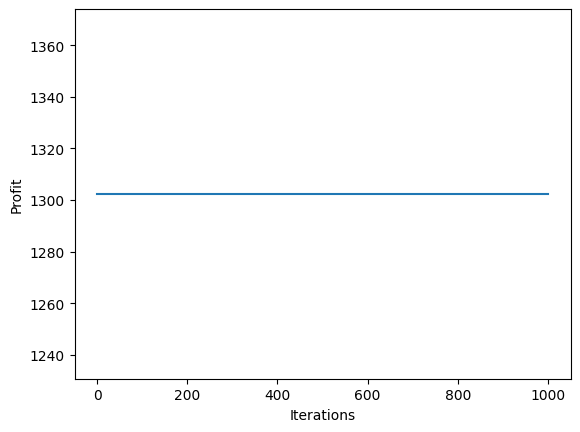

In [10]:
second_solver.visualize_graph()

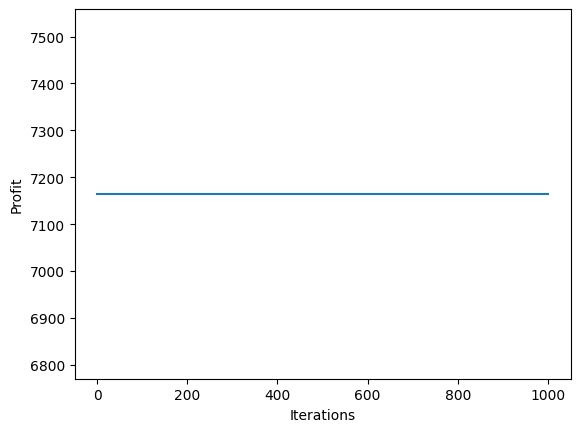

In [11]:
third_solver.visualize_graph()

##### Route Visualization

In [12]:
first_map = first_solver.visualize_solution(route_color = "red", prefix="A")
second_map = second_solver.visualize_solution(route_color="green", m=first_map, prefix="B")
third_map = third_solver.visualize_solution(route_color="magenta", m=second_map, prefix="C")
third_map

### Adaptive Genetic Algorithm

#### Solution Class

In [13]:
class AdaptiveGACarSharingSolver:
    def __init__(
        self,
        depot_nodes,
        pickup_nodes,
        dropoff_nodes,
        trip_matrix,
        pop_size,
        iterations,
        num_parents,
        mutation_const,
        crossover_prob,
        pre_avoid = [],
        post_avoid = []
    ):

        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.pop_size = pop_size
        self.iterations = iterations
        self.num_parents = num_parents
        self.mutation_const = mutation_const
        self.crossover_prob = crossover_prob
        self.population = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid
        random.seed(21) # arbitrary random seed to make results reproducible

    def crossover(parent1, parent2):
        return ordOne_crossover(parent1, parent2)

    def mutation(permutation):
        return swap_mutation(permutation)

    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        #print(route)
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def initial_population(self):
        self.population = [
            self.random_solution()
            for _ in range(self.pop_size)
        ]
        self.costs = self.fitness(self.population)
   
    # Single vehicle, genetic algorithm
    def run(self):
        # Check that initial population exists:
        if self.population:
            # Show some information
            print("Initial Population costs:")
            print(self.costs)
        else:
            raise Exception("Population not initialized.")
        sig = 0.5 #initial mutation probability
        mutation_tracker = []
        max_mutation = 0
        for x in range(self.iterations):
            self.costs = self.fitness(self.population)
            self.states.append(max(self.costs))
            mutation_tracker.extend(self.costs)
            if x % 10 == 0: #every 10th iteration adapts probability of adaptation based on # of successes in previous itetations
                z = len([1 for i in mutation_tracker if i >= max_mutation])
                if (z/len(mutation_tracker)*100) > 20:
                    sig = sig/self.mutation_const
                elif (z/len(mutation_tracker)*100) < 20:
                    sig = sig*self.mutation_const
                else: 
                    sig = sig
                max_mutation = max(mutation_tracker)
                mutation_tracker = []
                
            
            # Select the parents, we want to maximize the profit
            parents = nlargest(self.num_parents,self.population, key=lambda x: self.costs[self.population.index(x)])
            # Need to remove depots from the routes
            parents = [x[1:-1] for x in parents]
            offspring = []
            new_population = []
            for p1, p2 in zip(parents[:len(parents)//2],parents[len(parents)//2:]):
                # Crossover probability
                if random.random() < self.crossover_prob:
                    offspring.append(GACarSharingSolver.crossover(p1,p2))
                    offspring.append(GACarSharingSolver.crossover(p2,p1))
                else:
                    offspring.append(p1)
                    offspring.append(p2)
            for child in offspring:
                if random.random() < sig:
                    new_population.append(GACarSharingSolver.mutation(child))
                else:
                    new_population.append(child)
            new_population.extend(parents)
            self.population = [self.find_depots(route) for route in new_population]

        # Show best solution
        self.costs = self.fitness(self.population)
        self.states.append(max(self.costs))
        self.solution = max(self.population,key= lambda x: self.costs[self.population.index(x)])
        self.solution_cost = self.costs[self.population.index(self.solution)]
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost)
        # print("States:", self.states)
        

    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

#### Single Vehicle Check

In [14]:
pop_size = 16
iterations = 1000
num_parents = 8
mutation_const = 0.85
crossover_prob = 0.7

solver = AdaptiveGACarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_const, 
    crossover_prob)

solver.initial_population()
solver.run()

Initial Population costs:
[5888.39, 6094.43, 5158.37, 6299.27, 1825.34, 8240.51, 5162.81, 6765.41, 2960.24, 7400.6, 9198.98, 7501.37, -2925.43, 5498.15, 2580.92, 1468.25]
Best Solution: [Name: 75 ID: 31812627, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: Loblaws ID: 31582988]
Best Solution Profits: 18300.59


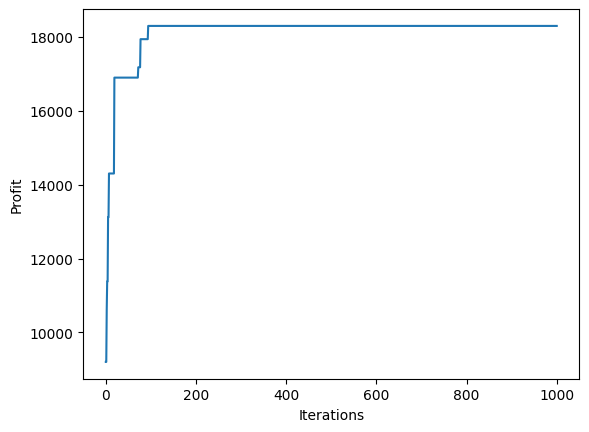

In [15]:
solver.visualize_graph()

##### Route Visualization

In [16]:
solver.visualize_solution()

#### 3 Vehicle Solution

In [17]:
pop_size = 16
iterations = 1000
num_parents = 8
mutation_const = 0.85
crossover_prob = 0.7

first_solver = AdaptiveGACarSharingSolver(
    depot_nodes, 
    first_pickups, 
    first_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_const, 
    crossover_prob)

print("Vehicle A")
first_solver.initial_population()
first_solver.run()

second_solver = AdaptiveGACarSharingSolver(
    depot_nodes, 
    second_pickups, 
    second_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_const, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0], first_solver.solution[-1]],
    post_avoid = [first_solver.solution[0], first_solver.solution[-1]])

print("\nVehicle B")
second_solver.initial_population()
second_solver.run()

third_solver = AdaptiveGACarSharingSolver(
    depot_nodes, 
    third_pickups, 
    third_dropoffs,
    trip_matrix, 
    pop_size, 
    iterations, 
    num_parents, 
    mutation_const, 
    crossover_prob,
    pre_avoid = [first_solver.solution[0], first_solver.solution[-1], second_solver.solution[0], second_solver.solution[-1]],
    post_avoid = [first_solver.solution[0], first_solver.solution[-1], second_solver.solution[0], second_solver.solution[-1]])

print("\nVehicle C")
third_solver.initial_population()
third_solver.run()

print("\nTotal profit:", first_solver.solution_cost + second_solver.solution_cost + third_solver.solution_cost)

Vehicle A
Initial Population costs:
[3410.79, 1942.56, 3410.79, 4403.22, 3410.79, 5555.04, 5555.04, 1942.56, 3410.79, 4403.22, 5555.04, 5555.04, 3410.79, 5441.22, 4403.22, 5555.04]
Best Solution: [Name: 93 ID: 4035051033, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 93 ID: 4035051033]
Best Solution Profits: 5555.04

Vehicle B
Initial Population costs:
[-1704.74, 404.47, -1704.74, 1302.37, -1704.74, -1704.74, -1704.74, 404.47, -1704.74, 1302.37, -1704.74, -1704.74, -1704.74, -54.32, 1302.37, -1704.74]
Best Solution: [Name: Optima ID: 96156270, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: Optima ID: 96156270]
Best Solution Profits: 1302.37

Vehicle C
Initial Population costs:
[4423.45, 1892.2, 7164.43, 2472.94, 5328.7

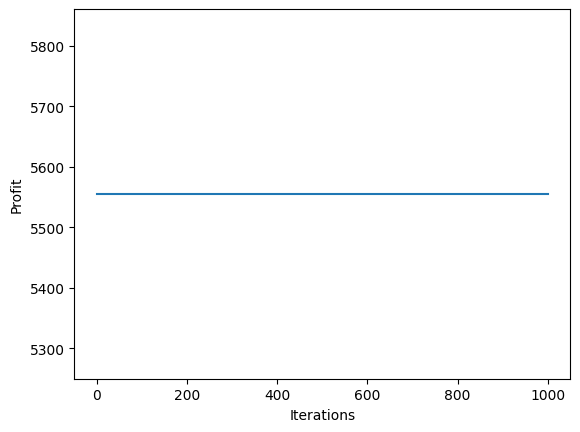

In [18]:
first_solver.visualize_graph()

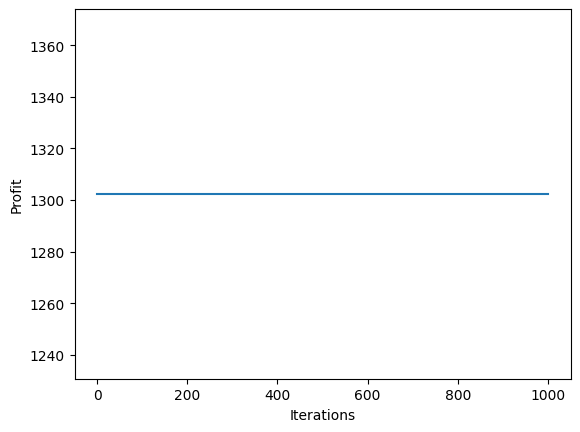

In [19]:
second_solver.visualize_graph()

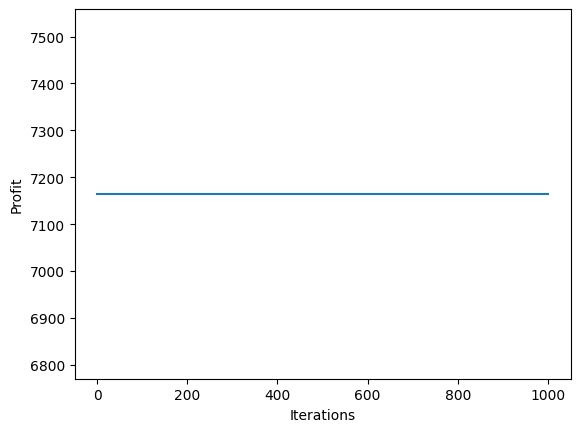

In [20]:
third_solver.visualize_graph()

##### Route Visualization

In [21]:
first_map = first_solver.visualize_solution(route_color="red", prefix="A")
second_map = second_solver.visualize_solution(route_color="green", m=first_map, prefix="B")
third_map = third_solver.visualize_solution(route_color="magenta", m=second_map, prefix="C")
third_map

### Particle Swarm Optimization

#### Solution Class

In [22]:
from smart_mobility_utilities.common import Node, cost, randomized_search
from smart_mobility_utilities.viz import draw_route
from smart_mobility_utilities.problem import cross_over
import random

class PSOCarSharingSolver:
    def __init__(self, depot_nodes, pickup_nodes, dropoff_nodes, trip_matrix, 
                 num_particles, num_swarms, iterations, w, c1, c2, pre_avoid = [], post_avoid = []):
        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.iterations = iterations
        self.num_particles = num_particles
        self.num_swarms = num_swarms
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.particles = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid
        random.seed(21) # arbitrary random seed to make results reproducible
        
    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def argmax(self, lst):
        # Based on https://towardsdatascience.com/there-is-no-argmax-function-for-python-list-cd0659b05e49
        return max(zip(lst, range(len(lst))))[1]
    
    def add(self, position, velocity):
        # Swap position indices according to velocity pairs (Lecture 6, slide 108)        
        if velocity == [[1, 1]]:
            return position

        for element in velocity:
            tmp = position[element[0]]
            position[element[0]] = position[element[1]]
            position[element[1]] = tmp
        
        return position
    
    def subtract(self, posA, posB):
        # Calculate a velocity by doing posA - posB (Lecture 6, slide 109)
        if len(posA) != len(posB):
            raise Exception("Positions need to be same length")
        
        if posA == posB:
            return [[1, 1]] #this velocity would not cause any changes, would mean swapping the first element with itself
        
        velocity = []
        for i in range(len(posA)):
            if posA[i] != posB[i]:
                for j in range(len(posB)):
                    if posB[j] == posA[i]:
                        velocity.append([i, j])
        
        return velocity
    
    def multiply(self, c, velocity):
        # Multiply a velocity by a constant (Lecture 6, slide 110)        
        if c == 0:
            return [[1, 1]]
        elif c > 0 and c < 1:
            #print("Result:", velocity[:round(c*len(velocity))], "\n")
            return velocity[:round(c*len(velocity))]
        elif c > 1:
            #print("Result:", velocity*(c // 1) + velocity[:round((c%1)*len(velocity))], "\n")
            return velocity*(int(c // 1)) + velocity[:round((c % 1)*len(velocity))]
        else:
            raise Exception("Constant is not valid value.")
        
    def initial_particles(self):
        self.particles = [self.random_solution() for _ in range(self.num_particles)]
        self.costs = self.fitness(self.particles)

    # Single vehicle PSO
    def run(self):
        # Check that initial particles exist:
        if self.particles:
            # Show some information
            print("Initial Particles costs:")
            print(self.costs, "\n")
        else:
            raise Exception("Particles not initialized.")
        
        #Initialize particle velocities to zero (single pair of same indices getting swapped)
        velocities = [[[1, 1]] for i in range(self.num_particles)]
       
        r1 = random.random()
        r2 = random.random()
        
        pps = self.num_particles // self.num_swarms # particles per swarm
        
        for iter_count in range(self.iterations):            
            #Updates for graphing iterations
            self.costs = self.fitness(self.particles)
            self.states.append(max(self.costs))
            
            # Segment particles into swarms
            swarms = []
            for i in range(self.num_swarms):
                swarms.append(self.particles[i * (pps): i*(pps) + pps])
            
            # Calculate best fitness for each particle, swarm, global for initial iteration
            if iter_count == 0:
                pBests_netProfit = self.fitness(self.particles)
                nBests_netProfit = [max(self.fitness(swarm)) for swarm in swarms]
                gBest_netProfit = max(nBests_netProfit)
                
                # Corresponding particle soultions
                pBests = [particle for particle in self.particles]
                nBests = [swarm[self.argmax(self.fitness(swarm))] for swarm in swarms]
                gBest = self.particles[self.argmax(self.fitness(self.particles))]
                            
            # Iterate over particles to update particle velocities and positions
            # Update nBest and gBest inside the loop (asynchronous method)
            particles = []
            for i, swarm in enumerate(swarms):
                for j, particle in enumerate(swarm):
                    # Remove start/end depot
                    particle = particle[1:-1]
    
                    inertial_velocity = self.multiply(self.w, velocities[j])
                    cognitive_velocity = self.multiply(self.c1*r1, self.subtract(pBests[j][1:-1], particle))
                    social_velocity = self.multiply(self.c2*r2, self.subtract(nBests[i][1:-1], particle))
                                               
                    # Update particle velocity
                    velocities[i*len(swarm) + j] = inertial_velocity + cognitive_velocity + social_velocity
                    
                    # Update particle position
                    particle = self.add(particle, velocities[i*len(swarm) + j])
                    
                    # Add back closest start/end depot to the particle
                    particle = self.find_depots(particle)
                    
                    particles.append(particle)
                               
                    # Update pBest
                    if pBests_netProfit[i*len(swarm) + j] < self.fitness([particle]):
                        pBests[i*len(swarm) + j] = deepcopy(particle)
                        pBests_netProfit[i*len(swarm) + j] = self.fitness([particle])
                    
                    # Update nBest
                    if nBests_netProfit[i] < self.fitness([particle]):
                        nBests[i] = deepcopy(particle)
                        nBests_netProfit[i] = self.fitness([particle])
                        
                    # Update gBest
                    if gBest_netProfit < self.fitness([particle]):
                        gBest = deepcopy(particle)
                        gBest_netProfit = self.fitness([particle])
            
            # Update self.particles to keep results of update steps
            self.particles = particles
                       
        # Update for end of last iteration
        self.costs = self.fitness(self.particles)
        self.states.append(max(self.costs))       
        
        # Show best solution
        self.solution = gBest 
        if isinstance(gBest_netProfit, list):
            self.solution_cost = gBest_netProfit[0]
        else:
            self.solution_cost = gBest_netProfit
        
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost, "\n")
        
    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

#### Single Vehicle Check

In [23]:
solver = PSOCarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=5000,
    w=0.8,
    c1=1.2,
    c2=1.5)

solver.initial_particles()
solver.run()

Initial Particles costs:
[5888.39, 6094.43, 5158.37, 6299.27, 1825.34, 8240.51, 5162.81, 6765.41, 2960.24, 7400.6, 9198.98, 7501.37, -2925.43, 5498.15, 2580.92, 1468.25, 321.92, 2251.64, 913.07, 9047.15] 

Best Solution: [Name: 75 ID: 31812627, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: 93 ID: 4035051033]
Best Solution Profits: 18388.49 



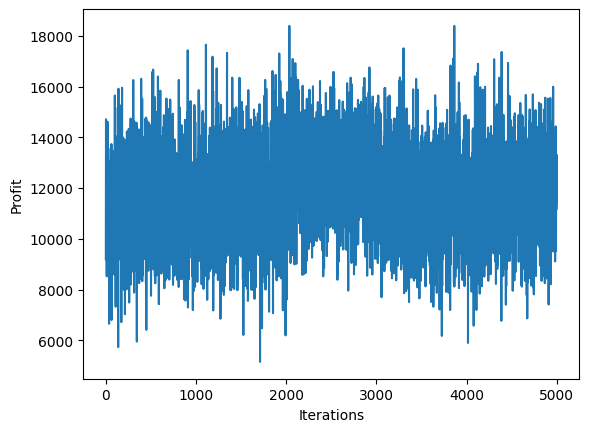

In [24]:
solver.visualize_graph()

##### Route Visualization

In [25]:
solver.visualize_solution()

#### Vehicle Partitioning for 3 Vehicle Solution

While completing this assignment, it was noticed that moving node 0 to be taken care of by vehicle B rather than vehicle A provides a better overall solution. This means that vehicle A only takes care of node 1 and 4. Given difficulties in implementing the genetic algorithm for less than 3 nodes, this change was made to only use with the PSO algorithms.

In [26]:
import folium
from folium import Map, Marker, PolyLine, Icon

m = Map(location=pickup_nodes[0].coordinates[::-1], zoom_start=11)
icon_colors = ["#2e86ab","#a23b72","#f18f01","#c73e1d","#fe5f55", "#8ac926", "#ca6163", "#d1345b", "#bof2b4", "#f0e100"]

# Arbitrary partitions
first_vehicle_index = [1, 4]
second_vehicle_index = [0, 7, 8, 9]  
third_vehicle_index = [3, 5, 6, 2]

for i, x in enumerate(pickup_nodes):
    if pickup_nodes.index(x) in first_vehicle_index:
        c  = "black"
    if pickup_nodes.index(x) in second_vehicle_index:
        c = "lightgray"
    if pickup_nodes.index(x) in third_vehicle_index:
        c = "lightblue"
    
    # Plot pickup point with user icon
    Marker(location=x.coordinates[::-1], 
           popup="Pickup Node " + str(i) + "\n" + str(x.coordinates),
           icon=folium.Icon(color=c, icon_color=icon_colors[i], icon='user', prefix='fa')).add_to(m)
    
    # Plot dropoff point with home icon
    Marker(location=dropoff_nodes[i].coordinates[::-1], 
           popup="Dropoff Node " + str(i) + "\n" + str(dropoff_nodes[i].coordinates),
           icon=folium.Icon(color=c, icon_color=icon_colors[i], icon='home', prefix='fa')).add_to(m)

bathurst_start = [43.82720773214452, -79.45379689449601]
bathurst_end = [43.636628218276, -79.3998242335392]
PolyLine([bathurst_start, bathurst_end], color="red").add_to(m)

m

In [27]:
first_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in first_vehicle_index]
first_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in first_vehicle_index]
second_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in second_vehicle_index]
second_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in second_vehicle_index]
third_pickups = [x for x in pickup_nodes if pickup_nodes.index(x) in third_vehicle_index]
third_dropoffs = [x for x in dropoff_nodes if dropoff_nodes.index(x) in third_vehicle_index]

#### 3 Vehicle Solution

In [28]:
first_solver = PSOCarSharingSolver(
    depot_nodes, 
    first_pickups, 
    first_dropoffs,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=1000,
    w=0.8,
    c1=1.2,
    c2=1.5)

print("Vehicle A")
first_solver.initial_particles()
first_solver.run()

second_solver = PSOCarSharingSolver(
    depot_nodes, 
    second_pickups, 
    second_dropoffs,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=1000,
    w=0.8,
    c1=3,
    c2=1,
    pre_avoid = [first_solver.solution[0], first_solver.solution[-1]],
    post_avoid = [first_solver.solution[0], first_solver.solution[-1]])

print("Vehicle B")
second_solver.initial_particles()
second_solver.run()

third_solver = PSOCarSharingSolver(
    depot_nodes, 
    third_pickups, 
    third_dropoffs,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=1000,
    w=0.8,
    c1=3,
    c2=1,
    pre_avoid = [first_solver.solution[0], first_solver.solution[-1], second_solver.solution[0], second_solver.solution[-1]],
    post_avoid = [first_solver.solution[0], first_solver.solution[-1], second_solver.solution[0], second_solver.solution[-1]])

print("Vehicle C")
third_solver.initial_particles()
third_solver.run()

print("Total profit:", first_solver.solution_cost + second_solver.solution_cost + third_solver.solution_cost)

Vehicle A
Initial Particles costs:
[4407.42, 1794.84, 1794.84, 1794.84, 4407.42, 4407.42, 1794.84, 4407.42, 4407.42, 1794.84, 1794.84, 1794.84, 4407.42, 4407.42, 4407.42, 4407.42, 4407.42, 1794.84, 4407.42, 4407.42] 

Best Solution: [Name: Loblaws ID: 31582988, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 93 ID: 4035051033]
Best Solution Profits: 4407.42 

Vehicle B
Initial Particles costs:
[-794.0, -1693.91, -3803.12, -3103.88, -3803.12, 1477.12, 1592.41, -3724.58, -1199.9, 856.42, -3803.12, -3803.12, -1199.9, -2600.51, 856.42, 856.42, -1199.9, 371.98, -3886.49, -794.0] 

Best Solution: [Name: 527 ID: 401220437, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: Optima ID: 96156270]
Best Solution Profits: 2310.58 

Vehic

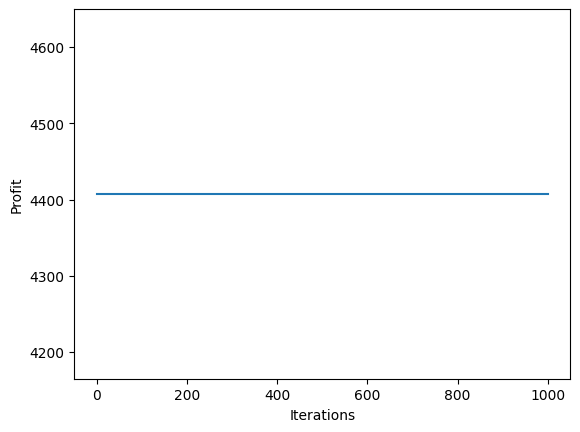

In [29]:
first_solver.visualize_graph()

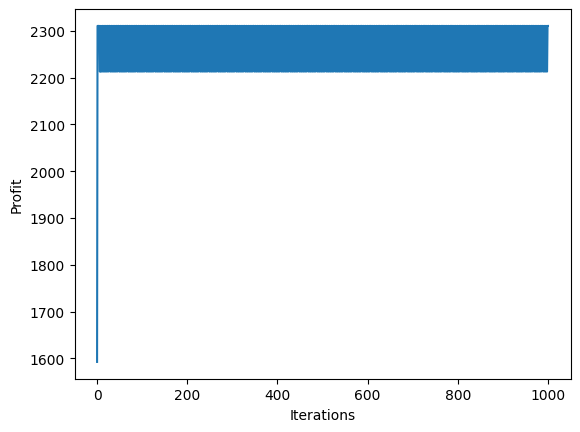

In [30]:
second_solver.visualize_graph()

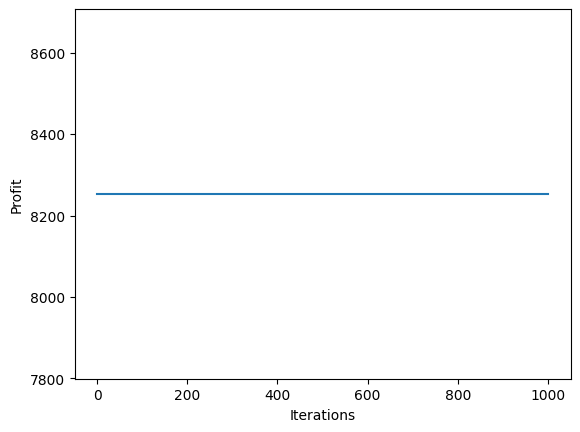

In [31]:
third_solver.visualize_graph()

##### Route Visualization

In [32]:
first_map = first_solver.visualize_solution(route_color="red", prefix="A")
second_map = second_solver.visualize_solution(route_color="green", m=first_map, prefix="B")
third_map = third_solver.visualize_solution(route_color="magenta", m=second_map, prefix="C")
third_map

### Adaptive Particle Swarm Optimization

#### Solution Class

In [33]:
class AdaptivePSOCarSharingSolver:
    def __init__(self, depot_nodes, pickup_nodes, dropoff_nodes, trip_matrix, num_particles, num_swarms, iterations,
                 w_max, w_min, c1_min, c1_max, c2_min, c2_max, pre_avoid = [], post_avoid = []):
        self.pickups = pickup_nodes
        self.depots = depot_nodes
        self.dropoffs = dropoff_nodes
        self.trip_matrix = trip_matrix
        self.iterations = iterations
        self.num_particles = num_particles
        self.num_swarms = num_swarms
        self.w_max = w_max
        self.w_min = w_min
        self.w = w_max
        self.c1_min = c1_min
        self.c1_max = c1_max
        self.c1 = c1_max
        self.c2_min = c2_min
        self.c2_max = c2_max
        self.c2 = c2_min
        self.particles = None
        self.costs = None
        self.states = []       
        self.solution = None
        self.solution_cost = None
        self.pre_avoid = pre_avoid
        self.post_avoid = post_avoid
        random.seed(21) # arbitrary random seed to make results reproducible
        
    # Find the closest depots for start and end, avoiding ones that are already filled
    def find_depots(self, route):
        start = route[0]
        end = route[-1]
        depots = deepcopy(self.depots)
        tmp_depots = deepcopy(depots)
        [depots.pop(depots.index(x)) for x in self.pre_avoid if x in depots]
        distances_to_start = [self.trip_matrix[x][start] for x in depots]
        [depots.pop(depots.index(x)) for x in self.post_avoid if x in depots]
        distances_from_end = [self.trip_matrix[end][x] for x in depots]
        start_depot = tmp_depots[distances_to_start.index(min(distances_to_start))]
        end_depot = tmp_depots[distances_from_end.index(min(distances_from_end))]
        route = [start_depot] + route + [end_depot]
        return route

    # Creates a random route for pickups and calls find_depots to organize route to choose depots closest to start and end pick up points for the complete route
    def random_solution(self):
        route = []
        can_visit = deepcopy(self.pickups)
        for i in range(len(self.pickups)):
            # select a random pickup location
            random_pickup = random.choice(can_visit)
            route.append(random_pickup)
            can_visit.pop(can_visit.index(random_pickup))

        # now we can choose the depot closest to starting and ending locations
        route = self.find_depots(route)
        return route

    def expand_route(self, route):
        actual_route = []
        for stop in route:
            if stop not in self.pickups:
                # It is a depot
                actual_route.append(stop)
                continue
            actual_route.append(stop)
            drop = self.dropoffs[self.pickups.index(stop)]
            actual_route.append(drop)
        return actual_route

    def fitness(self, solutions):
        result = []
        for vehicle_route in solutions:
            # We need to expand the routes into pickup-dropoffs to calculate actual cost
            expanded_route = self.expand_route(vehicle_route)
            total = 0
            for stop, next_stop in zip(expanded_route[:-1], expanded_route[1:]):
                if stop in self.pickups and next_stop in self.dropoffs:
                    cost_factor = 0.5
                else:
                    cost_factor = -0.3
                total += cost_factor * self.trip_matrix[stop][next_stop]
            result.append(round(total,2))
        return result
    
    def argmax(self, lst):
        # Based on https://towardsdatascience.com/there-is-no-argmax-function-for-python-list-cd0659b05e49
        return max(zip(lst, range(len(lst))))[1]
    
    def add(self, position, velocity):
        # Swap position indices according to velocity pairs (Lecture 6, slide 108)        
        if velocity == [[1, 1]]:
            return position

        for element in velocity:
            tmp = position[element[0]]
            position[element[0]] = position[element[1]]
            position[element[1]] = tmp
        
        return position
    
    def subtract(self, posA, posB):
        # Calculate a velocity by doing posA - posB (Lecture 6, slide 109)
        if len(posA) != len(posB):
            raise Exception("Positions need to be same length")
        
        if posA == posB:
            return [[1, 1]] #this velocity would not cause any changes, would mean swapping the first element with itself
        
        velocity = []
        for i in range(len(posA)):
            if posA[i] != posB[i]:
                for j in range(len(posB)):
                    if posB[j] == posA[i]:
                        velocity.append([i, j])
        
        return velocity
    
    def multiply(self, c, velocity):
        # Multiply a velocity by a constant (Lecture 6, slide 110)        
        if c == 0:
            return [[1, 1]]
        elif c > 0 and c < 1:
            #print("Result:", velocity[:round(c*len(velocity))], "\n")
            return velocity[:round(c*len(velocity))]
        elif c > 1:
            #print("Result:", velocity*(c // 1) + velocity[:round((c%1)*len(velocity))], "\n")
            return velocity*(int(c // 1)) + velocity[:round((c % 1)*len(velocity))]
        else:
            raise Exception("Constant is not valid value.")
        
    def initial_particles(self):
        self.particles = [self.random_solution() for _ in range(self.num_particles)]
        self.costs = self.fitness(self.particles)

    # Single vehicle PSO
    def run(self):
        # Check that initial particles exist:
        if self.particles:
            # Show some information
            print("Initial Particles costs:")
            print(self.costs, "\n")
        else:
            raise Exception("Particles not initialized.")
        
        #Initialize particle velocities to zero (single pair of same indices getting swapped)
        velocities = [[[1, 1]] for i in range(self.num_particles)]
       
        r1 = random.random()
        r2 = random.random()
        
        pps = self.num_particles // self.num_swarms # particles per swarm
        
        for iter_count in range(self.iterations):            
            #Updates for graphing iterations
            self.costs = self.fitness(self.particles)
            self.states.append(max(self.costs))
            
            # Segment particles into swarms
            swarms = []
            for i in range(self.num_swarms):
                swarms.append(self.particles[i * (pps): i*(pps) + pps])
            
            # Calculate best fitness for each particle, swarm, global for initial iteration
            if iter_count == 0:
                pBests_netProfit = self.fitness(self.particles)
                nBests_netProfit = [max(self.fitness(swarm)) for swarm in swarms]
                gBest_netProfit = max(nBests_netProfit)
                
                # Corresponding particle soultions
                pBests = [particle for particle in self.particles]
                nBests = [swarm[self.argmax(self.fitness(swarm))] for swarm in swarms]
                gBest = self.particles[self.argmax(self.fitness(self.particles))]
                        
            # Iterate over particles to update particle velocities and positions
            # Update nBest and gBest inside the loop (asynchronous method)
            particles = []
            for i, swarm in enumerate(swarms):
                for j, particle in enumerate(swarm):
                    # Remove start/end depot
                    particle = particle[1:-1]
    
                    inertial_velocity = self.multiply(self.w, velocities[j])
                    cognitive_velocity = self.multiply(self.c1*r1, self.subtract(pBests[j][1:-1], particle))
                    social_velocity = self.multiply(self.c2*r2, self.subtract(nBests[i][1:-1], particle))
                                               
                    # Update particle velocity
                    velocities[i*len(swarm) + j] = inertial_velocity + cognitive_velocity + social_velocity
                    
                    # Update particle position
                    particle = self.add(particle, velocities[i*len(swarm) + j])
                    
                    # Add back closest start/end depot to the particle
                    particle = self.find_depots(particle)
                    
                    particles.append(particle)
                               
                    # Update pBest
                    if pBests_netProfit[i*len(swarm) + j] < self.fitness([particle]):
                        pBests[i*len(swarm) + j] = deepcopy(particle)
                        pBests_netProfit[i*len(swarm) + j] = self.fitness([particle])
                    
                    # Update nBest
                    if nBests_netProfit[i] < self.fitness([particle]):
                        nBests[i] = deepcopy(particle)
                        nBests_netProfit[i] = self.fitness([particle])
                        
                    # Update gBest
                    if gBest_netProfit < self.fitness([particle]):
                        gBest = deepcopy(particle)
                        gBest_netProfit = self.fitness([particle])
            
            # Update self.particles to keep results of update steps
            self.particles = particles
                        
            #Implement Linear Time Varying Inertia Weight to make algorithm adaptive
            self.w = (self.w_max - self.w_min) * ((self.iterations - iter_count) / (self.iterations)) + self.w_min
            self.w = min(max(self.w_min, self.w), self.w_max)

            #Implement linearly decreasing c1 and linearly increasing c2 to make algorithm adaptive (based on Ratnaweera et al.)
            self.c1 = (self.c1_max - self.c1_min) * ((self.iterations - iter_count) / (self.iterations)) + self.c1_min
         
            self.c2 = self.c2_max - (self.c2_max - self.c2_min) * ((self.iterations - iter_count) / (self.iterations)) 
            
        # Update for end of last iteration
        self.costs = self.fitness(self.particles)
        self.states.append(max(self.costs))       
        
        # Show best solution
        self.solution = gBest 
        if isinstance(gBest_netProfit, list):
            self.solution_cost = gBest_netProfit[0]
        else:
            self.solution_cost = gBest_netProfit
        
        self.solution = self.expand_route(self.solution)
        print("Best Solution:", self.solution)
        print("Best Solution Profits:", self.solution_cost, "\n")
        
    def visualize_solution(self, m=None, route_color="red", prefix=""):
        # define marker colors
        colors = []
        for stop in self.solution:
            if stop in self.depots:
                colors.append('blue')
            if stop in self.pickups:
                colors.append('green')
            if stop in self.dropoffs:
                colors.append('red')
        return drawRouteOrder(
            [x.coordinates[::-1] for x in self.solution],
            self.solution,
            range(1,len(self.solution)+1), 
            colors=colors, route_color=route_color, m=m, prefix=prefix)
    
    def visualize_graph(self):
        plt.plot(self.states)
        plt.xlabel("Iterations")
        plt.ylabel("Profit")
        plt.show()    

#### Single Vehicle Check

In [34]:
solver = AdaptivePSOCarSharingSolver(
    depot_nodes, 
    pickup_nodes, 
    dropoff_nodes,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=5000,
    w_max=0.9,
    w_min=0.4,
    c1_min=0.3,
    c1_max=3,
    c2_min=0.4,
    c2_max=3.5)

solver.initial_particles()
solver.run()

Initial Particles costs:
[5888.39, 6094.43, 5158.37, 6299.27, 1825.34, 8240.51, 5162.81, 6765.41, 2960.24, 7400.6, 9198.98, 7501.37, -2925.43, 5498.15, 2580.92, 1468.25, 321.92, 2251.64, 913.07, 9047.15] 

Best Solution: [Name: 93 ID: 4035051033, Name: 444 ID: 4035049080, Name: 32 ID: 66412324, Name: 90 ID: 804610960, Name: Continental Tower ID: 103953736, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: Toronto Transit Commission ID: 32052212, Name: 2575 ID: 43805702, Name: St. Barnabas Anglican Church ID: 43811604, Name: Royal Bank Plaza North Tower ID: 27767624, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 93 ID: 4035051033]
Best Solution Profits: 18337.34 



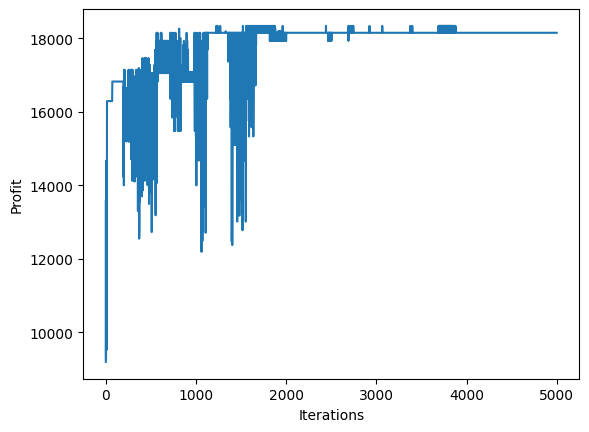

In [35]:
solver.visualize_graph()

##### Route Visualization

In [36]:
solver.visualize_solution()

#### 3 Vehicle Solution

In [37]:
first_solver = AdaptivePSOCarSharingSolver(
    depot_nodes, 
    first_pickups, 
    first_dropoffs,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=1000,
    w_max=0.9,
    w_min=0.4,
    c1_min=0.3,
    c1_max=3,
    c2_min=0.4,
    c2_max=3.5)

print("Vehicle A")
first_solver.initial_particles()
first_solver.run()

second_solver = AdaptivePSOCarSharingSolver(
    depot_nodes, 
    second_pickups, 
    second_dropoffs,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=1000,
    w_max=0.9,
    w_min=0.4,
    c1_min=0.3,
    c1_max=3,
    c2_min=0.4,
    c2_max=3.5,
    pre_avoid = [first_solver.solution[0], first_solver.solution[-1]],
    post_avoid = [first_solver.solution[0], first_solver.solution[-1]])

print("Vehicle B")
second_solver.initial_particles()
second_solver.run()

third_solver = AdaptivePSOCarSharingSolver(
    depot_nodes, 
    third_pickups, 
    third_dropoffs,
    trip_matrix,
    num_particles=20,
    num_swarms=5, 
    iterations=1000,
    w_max=0.9,
    w_min=0.4,
    c1_min=0.3,
    c1_max=3,
    c2_min=0.4,
    c2_max=3.5,
    pre_avoid = [first_solver.solution[0], first_solver.solution[-1], second_solver.solution[0], second_solver.solution[-1]],
    post_avoid = [first_solver.solution[0], first_solver.solution[-1], second_solver.solution[0], second_solver.solution[-1]])

print("Vehicle C")
third_solver.initial_particles()
third_solver.run()

print("Total profit:", first_solver.solution_cost + second_solver.solution_cost + third_solver.solution_cost)

Vehicle A
Initial Particles costs:
[4407.42, 1794.84, 1794.84, 1794.84, 4407.42, 4407.42, 1794.84, 4407.42, 4407.42, 1794.84, 1794.84, 1794.84, 4407.42, 4407.42, 4407.42, 4407.42, 4407.42, 1794.84, 4407.42, 4407.42] 

Best Solution: [Name: Loblaws ID: 31582988, Name: Bayview Avenue ID: 2525612330, Name: 15 ID: 803174456, Name: 799 ID: 401062600, Name: 49 ID: 804609495, Name: 93 ID: 4035051033]
Best Solution Profits: 4407.42 

Vehicle B
Initial Particles costs:
[-794.0, -1693.91, -3803.12, -3103.88, -3803.12, 1477.12, 1592.41, -3724.58, -1199.9, 856.42, -3803.12, -3803.12, -1199.9, -2600.51, 856.42, 856.42, -1199.9, 371.98, -3886.49, -794.0] 

Best Solution: [Name: 527 ID: 401220437, Name: 565 ID: 803149738, Name: 31 ID: 803176775, Name: Bloor Street West ID: 2286883372, Name: 40 ID: 72376319, Name: The Squire and Firkin ID: 2287594369, Name: 53 ID: 67739858, Name: October Convenience ID: 588647080, Name: 35 ID: 67737319, Name: Optima ID: 96156270]
Best Solution Profits: 2310.58 

Vehic

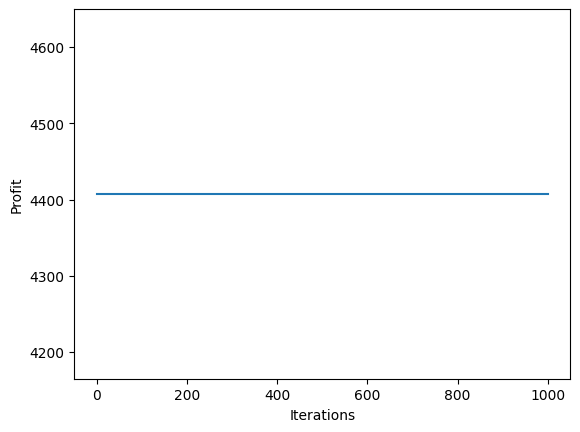

In [38]:
first_solver.visualize_graph()

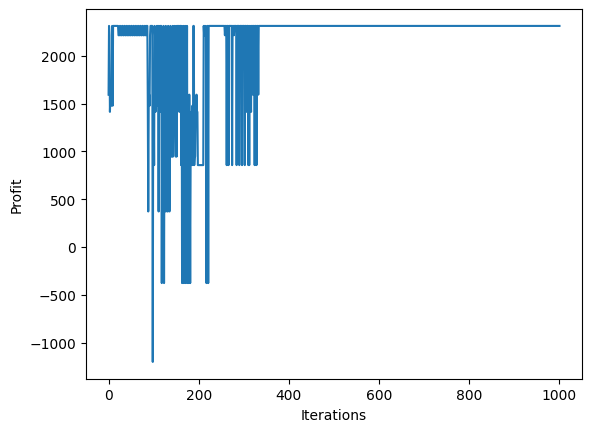

In [39]:
second_solver.visualize_graph()

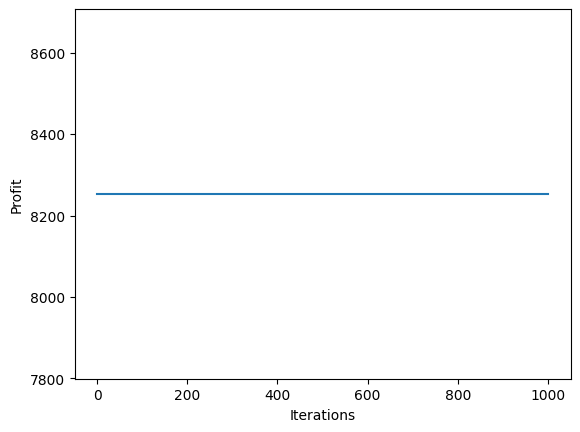

In [40]:
third_solver.visualize_graph()

##### Route Visualization

In [41]:
first_map = first_solver.visualize_solution(route_color="red", prefix="A")
second_map = second_solver.visualize_solution(route_color="green", m=first_map, prefix="B")
third_map = third_solver.visualize_solution(route_color="magenta", m=second_map, prefix="C")
third_map

### Comparison of Algorithms

To-do: "Conduct a comparative analysis on genetic algorithm, adaptive genetic algorithm, swarm intelligence algorithm and adaptive swarm intelligence algorithm in terms of the generated profit, CPU times and Wall time spent in getting the solutions"

Observations to include in write-up:
- same results for algos on 3 vehicle problem when using same partition, -> likely can't do better w/o changing partitioning
- one vehicle results are better than 3 vehicle. This is because of the modelling limitation of breaking the problem up into smaller subsets and then combining solutions. For the smaller subsets, there is less room to explore as compared to a larger solution space when all nodes are serviced by 1 vehicle. To get better results, the algorithms would need to be modified to handle multiple vehicles, and the results should be equal to or greater than the single vehicle case (unlike the results here).
- PSO generally took longer to run but gave better results for single vehicle. Convergence pattern for pso was worse. Adaptive PSO improved convergence pattern, but converged prematurely, so results were worse.


*Table 1 - Comparison for single vehicle problem instance*
|                                      | Profit   | CPU Time | Wall Time |  
|--------------------------------------|----------|----------|-----------|
| Genetic Algorithm                    | 18265.37 |          |           |   
| Adaptive Genetic Algorithm           | 18300.59 |          |           |   
| Particle Swarm Optimization          | 18388.49 |          |           |  
| Adaptive Particle Swarm Optimization | 18337.34 |          |           | 



*Table 2 - Comparison for 3 vehicle problem instance*
|                                      | Profit   | CPU Time | Wall Time |  
|--------------------------------------|----------|----------|-----------|
| Genetic Algorithm                    | 14021.84 |          |           |   
| Adaptive Genetic Algorithm           | 14021.84 |          |           |   
| Particle Swarm Optimization          | 14971.04 |          |           |  
| Adaptive Particle Swarm Optimization | 14971.04 |          |           | 